# Machine Learning for Forex

This model will use a linear regression to try to identify possible trend patterns on the pair USDJPY.

This is just a test to identify the capabilities of Technical indicators to predict future moves on the market  

In [4]:
import pandas as pd
df = pd.read_csv("USDJPY60.csv")
df.tail()

,Date,Hour,open,high,low,close,volume
66019,2022.12.09,19:00,136.402,136.507,136.331,136.463,3842
66020,2022.12.09,20:00,136.465,136.504,136.331,136.414,2627
66021,2022.12.09,21:00,136.411,136.504,136.373,136.469,2739
66022,2022.12.09,22:00,136.471,136.688,136.438,136.688,2788
66023,2022.12.09,23:00,136.687,136.709,136.503,136.527,2071


In [5]:
# clean the data, remove all the index that are Zero volume
index_zeros = df[df['volume'] == 0].index
df.drop(index_zeros, inplace = True)
df.loc[(df["volume"] == 0)]
df.isna().sum()

Date      0
Hour      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

## Here we are getting the values of technical indicators 

I had an hypothesis that will also try to test on other models, and is the slope of those indicators.
Let me elaborate more, i would like to test the effectivenes of the slope value with indicators and see if there is a possible edge to be explore.

What are we looking is a high number of predictibale moments on any of both trends (buy or sell)

In [15]:
import numpy as np
import pandas_ta as ta

df['ATR'] = df.ta.atr(length = 15)
df['RSI'] = df.ta.rsi(length = 13)
df['AVG'] = df.ta.midprice()
df['MA21'] = df.ta.ema(length=21)
df['MA50'] = df.ta.ema(length=50)
df['MA200'] = df.ta.ema(length=200)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope


backrolling_n= 12

df['slopeMA21'] = df['MA21'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeMA50'] = df['MA50'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeMA200'] = df['MA200'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeAVG'] = df['AVG'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeRSI'] = df['RSI'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeATR'] = df['ATR'].rolling(window=backrolling_n).apply(get_slope, raw=True)

In [16]:
df.tail()

,Date,Hour,open,high,low,close,volume,ATR,RSI,AVG,MA21,MA50,MA200,slopeMA21,slopeMA50,slopeMA200,slopeAVG,MyTarget,slopeRSI,slopeATR
66019,2022.12.09,19:00,136.402,136.507,136.331,136.463,3842,0.359220,53.830258,136.4285,136.298571,136.430701,136.924439,-0.013142,-0.012326,-0.008022,0.027974,NaN,1.312972,0.010495
66020,2022.12.09,20:00,136.465,136.504,136.331,136.414,2627,0.346805,52.439779,136.4190,136.309064,136.430047,136.919360,-0.009251,-0.010679,-0.007647,0.029119,NaN,1.188449,0.010220
66021,2022.12.09,21:00,136.411,136.504,136.373,136.469,2739,0.332418,53.888148,136.4175,136.323604,136.431574,136.914878,-0.004411,-0.008535,-0.007133,0.033645,NaN,1.522177,0.009377
66022,2022.12.09,22:00,136.471,136.688,136.438,136.688,2788,0.326923,59.242277,136.5305,136.356731,136.441630,136.912621,0.001585,-0.005787,-0.006449,0.042308,NaN,1.902360,0.007796
66023,2022.12.09,23:00,136.687,136.709,136.503,136.527,2071,0.318862,54.227626,136.5735,136.372210,136.444978,136.908784,0.007579,-0.002913,-0.005713,0.054892,NaN,1.928598,0.005387


On this Following area we will use a very basic risk management strategy but these items are to be tested and improved

In [17]:
# Targets are flexible
pip_difference = 500*1e-3 # this is -3 because we using a XXXJPY so the price goes as 132.123 and 500 means 50 pips
RRratio = 2 # this is the risk reward ratio the higher the better

def my_target(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length 
    
    for line in range (0,length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range (1,barsupfront +2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pip_difference) and (-valueOpenHigh <= (pip_difference/RRratio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pip_difference/RRratio)) and (-valueOpenHigh >= pip_difference) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [18]:
df['MyTarget'] = my_target(50,df)
df.head(5)

,Date,Hour,open,high,low,close,volume,ATR,RSI,AVG,MA21,MA50,MA200,slopeMA21,slopeMA50,slopeMA200,slopeAVG,MyTarget,slopeRSI,slopeATR
0,2012.04.13,17:00,80.975,81.021,80.912,80.967,3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,2012.04.13,18:00,80.969,81.007,80.893,80.988,2727,NaN,NaN,80.9570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,2012.04.13,19:00,80.986,81.006,80.940,80.945,1563,NaN,NaN,80.9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,2012.04.13,20:00,80.943,81.007,80.943,80.985,1684,NaN,NaN,80.9735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,2012.04.13,21:00,80.985,81.124,80.981,81.104,1551,NaN,NaN,81.0335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


<ipython-input-20-50f9187c4259>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_model.hist(ax = ax)


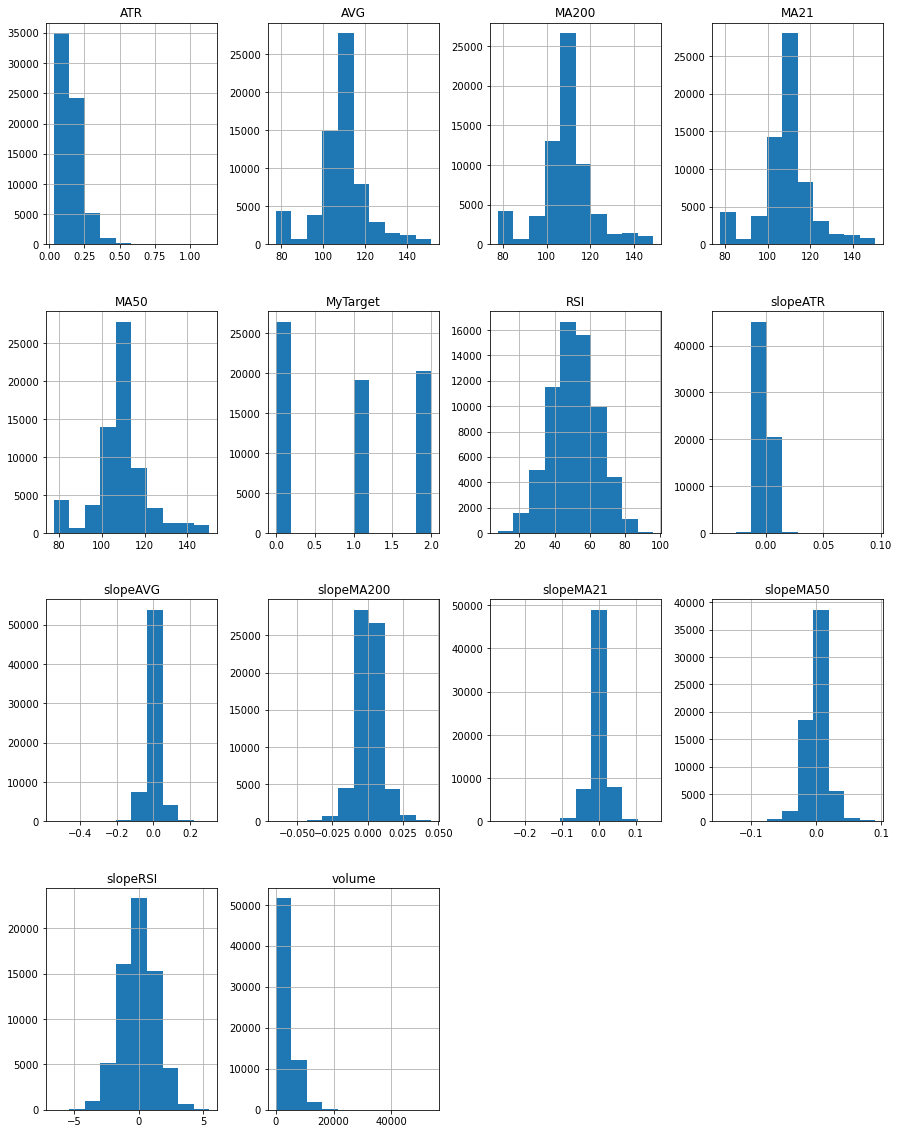

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'AVG', 'MA21', 'MA50', 'MA200', 'slopeMA21', 'slopeMA50', 'slopeMA200', 'slopeAVG', 'slopeRSI', 'slopeATR', 'MyTarget']] 
df_model.hist(ax = ax)
plt.show()

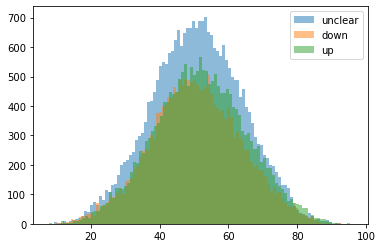

In [21]:
from matplotlib import pyplot
df_up=df.RSI[ df['MyTarget'] == 2 ]
df_down=df.RSI[ df['MyTarget'] == 1 ]
df_unclear=df.RSI[ df['MyTarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

Unfortunatly the results are not that good, since there is more unclear trends than either way, therefore this could be failing approach, next steps is try to find a corelation with deltas on volume.